#  Compressed Sensing for 1-D signals

The compressed sensing problem aims to reconstruct the signals that are sampled much below the Nyquist Sampling criteria. In this example, we look at how compressed sensing can be used in reconstructing a one-dimensional signal, for example audio signals.

Compressed sensing has been developed out of the idea that the “information rate” of a continuous time signal may be much smaller than suggested by its bandwidth. More precisely, Compressed Sensing exploits the fact that many natural signals are sparse or compressible in the sense that they have concise representations when expressed in the proper basis  $\Psi$.

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import cvxpy as cvx
import scipy.ndimage as spimg

### Sinusoidal Signal

Consider the sum of sinusoids given by the equation:
$X = sin(300\pi t) + 0.5*cos(200\pi t)$
Since this signal consists of limited frequency content, its sparse in the frequency/spectral domain. Hence an undersampled version of this signal can be used to approximately reconstruct the signal through Compressed Sensing.

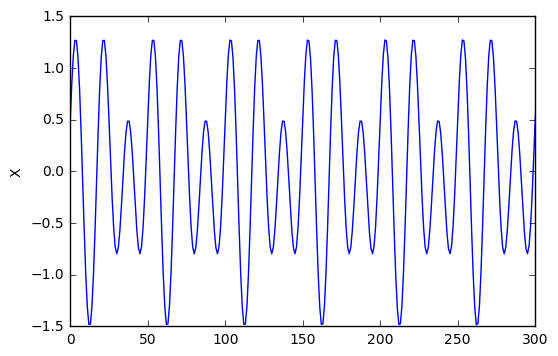

In [4]:
n = 5000
t = np.linspace(0, 2, n)
x = np.sin(300 * np.pi * t) + 0.5*np.cos(200 * np.pi * t)
plt.plot(x)
plt.ylabel('X')
plt.xlim((0,300))
plt.show()

This signal can be represented in the frequency domain, in which it is sparse, using a Discrete Cosine Transform that transforms a signal in spatial domain to frequency domain.
From the plot below, we can clearly see that the signal is sparse in the frequency domain, with spikes only at a couple of frequencies and zeros elsewhere.

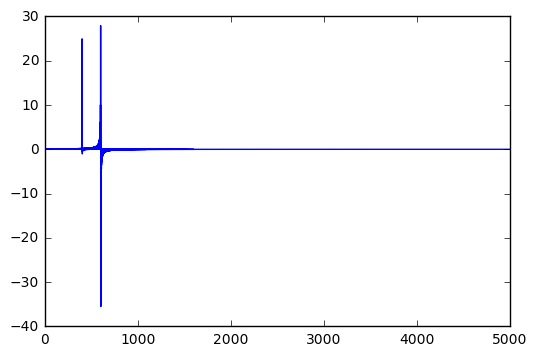

In [5]:
x_tr = spfft.dct(x, norm='ortho')
plt.plot(x_tr)
plt.show()

Compressed sensing exploits this sparsity in the frequency domain to reconstruct the signal with only a few samples. Firstly, we take a random measurement from the signal only capturing 10% of its actual information. This random measurement along with the prior knowledge on the sampling process and the sparsity of signal in the frequency domain become crucial in addressing the reconstruction of the signal.

The plot below depicts how we select only $10\%$ (red dots) of the available data by first generating $500$ random numbers in the range of $0-N$, $N = length\ of\ the\ signal$ and then sampling only at the generated time points.

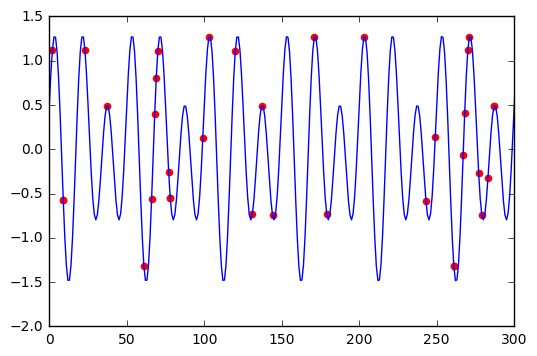

In [6]:
m = 500
r = np.random.choice(n,m,replace='false')
r.sort()
t_r = t[r]
y = x[r]

plt.plot(x)
plt.scatter(r,y,color='r')
plt.xlim((0,300))
plt.show()

We now have an observation from which we aim to reconstruct our original signal. 

Based on the sparsity and incoherence assumptions of Compressed Sensing, the target signal $f$ can be sparsely represented in the frequency domain based using a DCT basis $\Psi$:

$f = \Psi x$

Now, the sparse measurement is a random sampling operation on the signal $f$, that can be represented using the measurement basis $\Phi$

$y = \Phi f$

We know that the $L1$ norm is a good constraint in finding a sparse solution, so the problem now aims to find a sparse vector $x$ that closely produces the obsserved measurement $y$. This can be solved using a $L1$ minimization problem constrained on  $||y-\Phi \Psi x||^2$

$arg\ min(x)\ |x|\ s.t.\ ||y-\Phi \Psi x||^2$ ,  $where\ |.|\ denotes\ the\ L1\ norm,\ and\ ||.||\ is\ the\ L2\ norm$ 

We therefore construct our matrix operator A that performs both a sampling and a transformation from spectral to temporal domains using the inverse Discrete Cosine Transform.

$A\ =\ \Phi \Psi$, Since $\Phi$ is a random matric, any fixed matrix $\Psi$ is maximally incoherent with $\Phi$, thus satisfying the incoherent criteria for the measurement and sparsity basis. This optimization is looking for the solution to $Ax=y$ with the smallest $L1$ norm for $x$.

In [7]:
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[r]

In [8]:
# L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == y]
prob = cvx.Problem(objective, constraints)
result = prob.solve()

Once the optimization algorithm produces an estimate of the sparse signal $x$ that is a representation of our original signal $f$ in the DCT domain, we can reconstruct the original signal through an inverse discrete cosine transform.

In [26]:
# reconstruct signal
x_spr = np.array(vx.value)
x_spr = np.squeeze(x_spr)
sig = spfft.idct(x_spr, norm='ortho', axis=0)

The plot below depicts the original signal in green and its sparse reconstruction in red. One problem that stands out is that the quality of the reconstruction degrades noticeably at and around $t=0$. This is probably due to our sample interval violating the periodic boundary condition requirements of the cosine transform. However, the reconstruction is fairly accurate elsewhere.

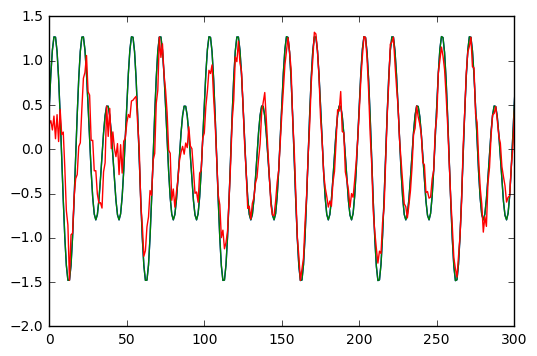

In [27]:
plt.plot(x)
plt.plot(sig)
plt.xlim((0,300))
plt.show()

Now, we try to obtain a reconstruction using the L-2 norm instead of the L-1 norm:

In [9]:
#L2 optimization
vx_2 = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx_2, 2))
constraints = [A*vx_2 == y]
prob = cvx.Problem(objective, constraints)
result = prob.solve()

In [29]:
# reconstruct signal
x2_spr = np.array(vx_2.value)
x2_spr = np.squeeze(x2_spr)
sig2 = spfft.idct(x2_spr, norm='ortho', axis=0)

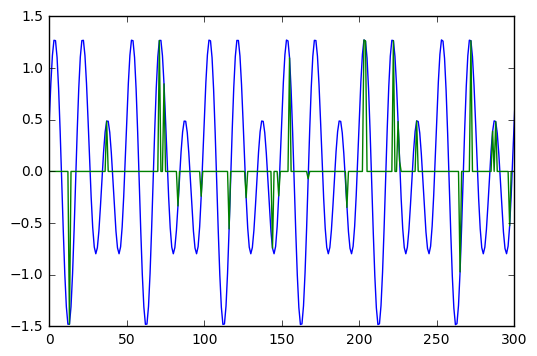

In [30]:
plt.plot(x)
plt.plot(sig2)
plt.xlim((0,300))
plt.show()

Clearly, the L-2 norm does not do a good job in accurately reconstructing the signal and hence, L-2 is not a efficient reconstruction criteria in the sparse framework.